In [2]:
%matplotlib inline

import os
import tarfile
# from six.moves import urllib
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


# fetch_housing_data()
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
#Note: total_bedrooms has missing data

#Note: ocean_proximity is not a numeric field, it's text
display(housing['ocean_proximity'].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
#Now we know the entire set of categories involved

# Map text properties to numeric
ocean_prox, ocean_prox_idx = housing['ocean_proximity'].factorize()

ocean_prox_idx

Index(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype='object')

In [6]:
ocean_prox

array([0, 0, 0, ..., 2, 2, 2])

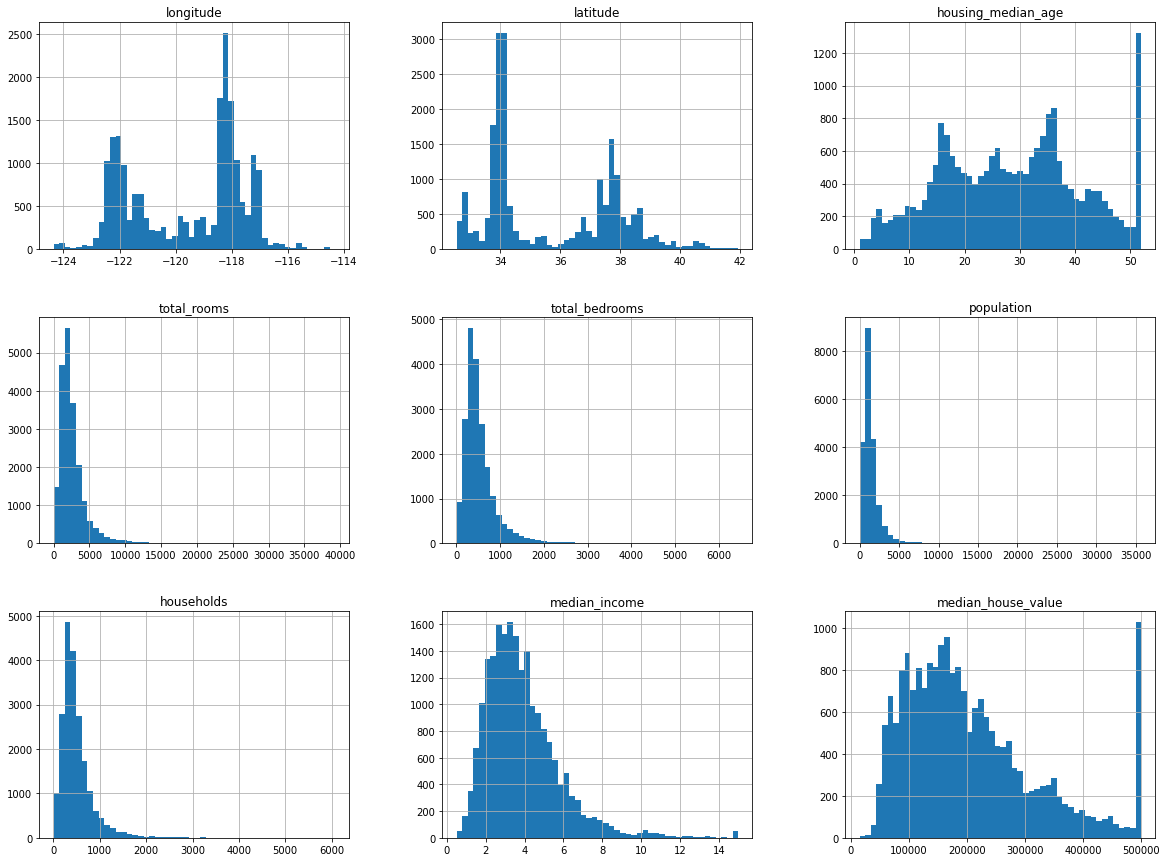

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

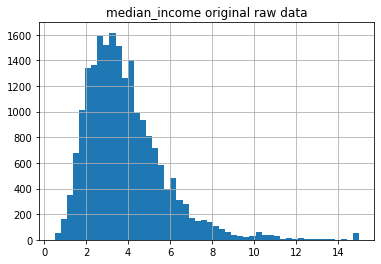

In [8]:
# Setting up training sets is not always that straight forward.  Predicting housing prices seems to have a strong
# dependence on a buyers income, so median_income is likely important.
#
# Let's create an income category to cluster incomes into integer classes used to stratify the data 
# Note: we will need significant amounts within each group which we'll check-up on
#
# Visually between 1.5 to 5 we see most of the data and most of the data tails-off 8 and higher
# But the book says 2-5 cap 5 or 6.  Why? Because of the following...

housing['median_income'].hist(bins=50).set_title('median_income original raw data')
plt.show()

In [9]:
# the plot is nice, but I really need the numbers 
# to make this look gausian, I need to get the Central Tendency of the median_income +/- standard_dev

housing['median_income'].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

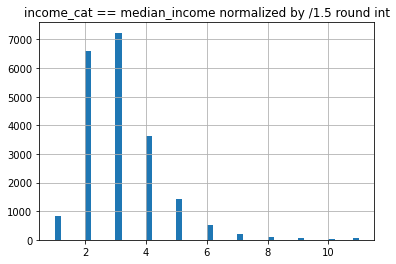

In [10]:
# Visually we see the center of the distribution coincides with th 50%_percentile, but the numeric breakdown
# using he describe function shows the arithmatic mean ~4. 
# 
# To create a guiassian normal distrubtion for the income category we might do the following:
#
# Use the 50%_percentile ~3.5 and std ~2
# So (mean-sigma = 1.5) and (mean+sigma = 5.5) 
#
# dividing all values by 1.5 (as a normalization factor) means values below 1.5 are less than 1
# and values starting at 1.5 become a category value of 1, and >1 become fractions rounded-up to int values

housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].hist(bins=50).set_title('income_cat == median_income normalized by /1.5 round int')

plt.show()

In [11]:
housing['income_cat'].describe()

count    20640.000000
mean         3.093362
std          1.303707
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: income_cat, dtype: float64

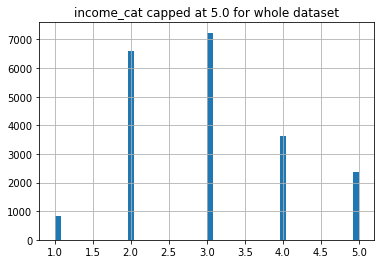

In [47]:
#Note: we want to clip the income_cat above the 75%_tile, so replace everything higher than 5 with a 5.0

housing['income_cat'].where(housing['income_cat']<5, other=5.0, inplace=True)
housing['income_cat'].hist(bins=50).set_title('income_cat capped at 5.0 for whole dataset')
plt.show()

In [12]:
# Plots are nice, but what are the values
housing['income_cat'].value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

In [13]:
# It's a good idea to put a unique id field in the data so we can use it to check data-set updates for dups etc
#
housing["id"] = (housing["longitude"] * housing["latitude"]) + housing.index.values 

print('Is id formulation unique:', housing['id'].is_unique)

Is id formulation unique: True


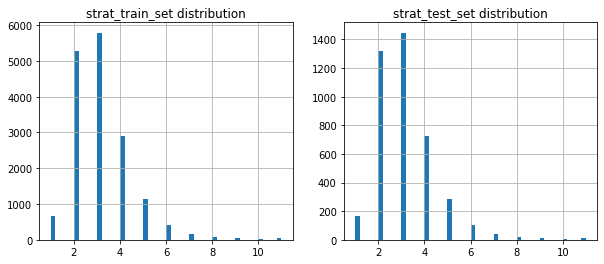

In [14]:
# Now we have a unique identifier that's relatively normal in distribution, we should split the data
# Never looking at the full dataset prevents what Data Science calls
#
### Snooping Bias
#
# Set aside 20% as never viewed for testing, and work with 80% for training
#
# This code block IS how we will randomly split the data into training and test constrained to the 'income_cat'
# distribution

from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in strat_split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Use subplots to plot multiple charts side-by-side
fig, ax = plt.subplots(1,2, figsize=(10,4))
strat_train_set['income_cat'].hist(bins=50, ax=ax[0]).set_title('strat_train_set distribution')
strat_test_set['income_cat'].hist(bins=50, ax=ax[1]).set_title('strat_test_set distribution')

plt.show()

In [15]:
# Charts are great for interactive viewing, but get numbers for percent representation in each category

# Getting more sophisticated, let's generate 3 data frames (full-set, train, and test)
# merge them into a new dataframe so we can put it up side-by-side

dist_pcts = pd.concat([
    housing['income_cat'].value_counts()/len(housing)*100,
    strat_train_set['income_cat'].value_counts()/len(strat_train_set)*100, 
    strat_test_set['income_cat'].value_counts()/len(strat_test_set)*100
], axis=1)

# label the columns and display them
dist_pcts.columns = ['%in_cat full', '%in_cat train', '%in_cat test']

display(dist_pcts)

,%in_cat full,%in_cat train,%in_cat test
3.0,35.058140,35.059351,35.053295
2.0,31.884690,31.885901,31.879845
4.0,17.630814,17.629603,17.635659
5.0,6.894380,6.891957,6.904070
1.0,3.982558,3.984981,3.972868
6.0,2.577519,2.579942,2.567829
7.0,0.915698,0.914486,0.920543
8.0,0.508721,0.508721,0.508721
9.0,0.242248,0.242248,0.242248
11.0,0.237403,0.236192,0.242248


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

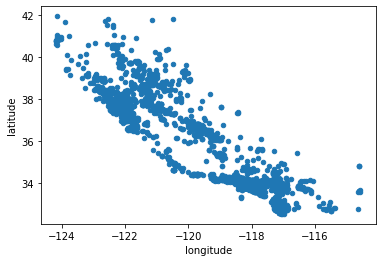

In [16]:
# Now that we have a stratified Training and Test set, the Data Engineer might publish the data using a DF.write
# Then make that available to the Data Science team
#
# Hey guess what, we're writing duplicate data just broken-out by test & train... 
# and looking ahead we also need to setup some random 'cross-validation' sets
#
# *** For this SIMPLE DEMO, I'm not going to write the split data back, and reload it
# But for NetApp folks, this is where a Data Scientist starts interactive exploration and Feature Engineering work

strat_test_set.plot(kind='scatter', x='longitude', y='latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

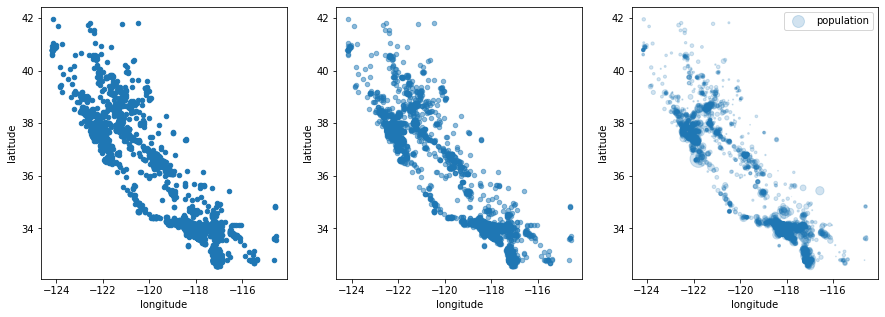

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', ax=ax[0])
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, ax=ax[1])
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, s=strat_test_set['population']/100, 
                    label='population', ax=ax[2])

Text(0.5, 1.0, 'Median House Value')

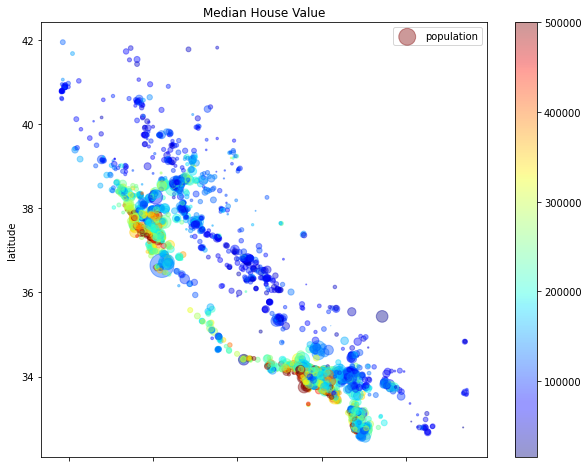

In [18]:
strat_test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
                    s=strat_test_set['population']/50, label='population', figsize=(10,8), 
                    c=strat_test_set['median_house_value'], cmap=plt.get_cmap('jet'))
plt.title('Median House Value')

In [19]:
# for a small enough data_set we can use the standard correlation coefficient aka Pearson's r correlation
# where 1 means strong positive, and -1 means strong inverse correlation
#
corr_matrix = strat_test_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)
FS1 = corr_matrix['median_house_value'].sort_values(ascending=False).copy()
display(FS1)

median_house_value    1.000000
median_income         0.690517
income_cat            0.672175
total_rooms           0.127460
id                    0.108698
housing_median_age    0.080876
households            0.066136
total_bedrooms        0.051907
population           -0.024193
longitude            -0.049608
latitude             -0.142077
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

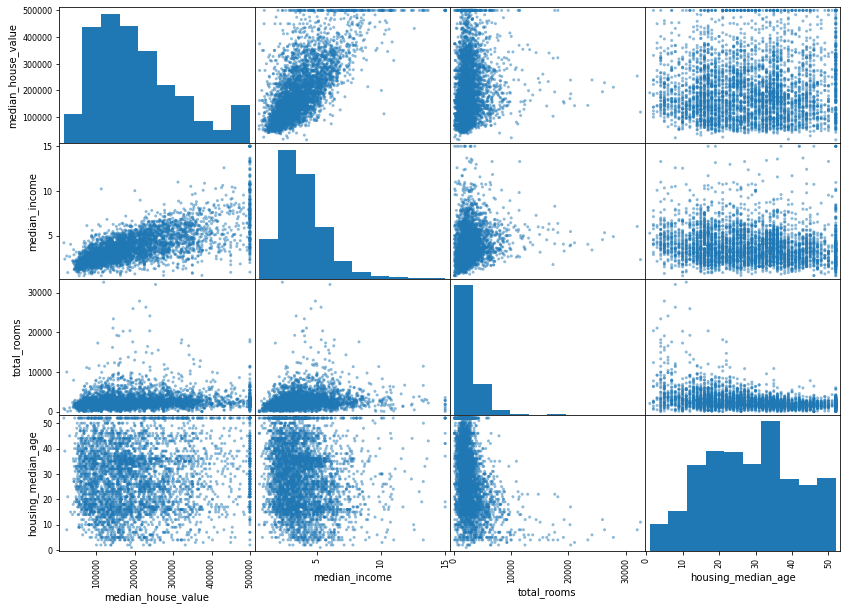

In [20]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity']
scatter_matrix(strat_test_set[attributes], figsize=(14,10))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

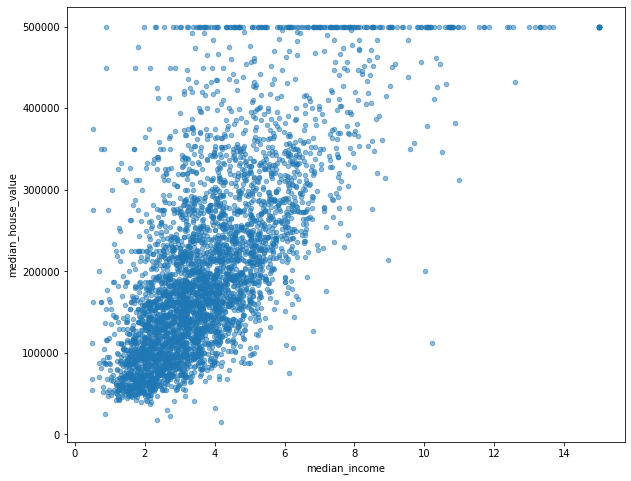

In [21]:
# Take a closer look at median_income vs median_house_value
#
strat_test_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, figsize=(10,8))
#
# Note: A line at 500000, clusters at 450000, and 350000 in median_house_value

In [22]:
# Start of Feature Engineering
#
# It doesn't look like we have a ton of features showing some form of linear or non-linear correlation
#
# This is where "Domain Expertises" comes into play.  Someone with more real estate sales experience might
# provide added insights like...
#
# * The total number of rooms in a district is not very useful if you don’t know how many households there are. 
# * Maybe we really want number of rooms per household. 
# * The total number of bedrooms by itself is not very useful: maybe compare it to the number of rooms as a ratio
# * And the population per household also seems like an interesting attribute 

housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# In some cases there are hundres of rooms: wondering if there's a relationship?
housing['income_to_rooms'] = housing['median_income'] / housing['total_rooms']
housing['income_to_bedrooms'] = housing['median_income'] / housing['total_bedrooms']

# There is also a noticable break-down of a trend between 'total_rooms' and 'housing_median_age'
# fewer total_rooms in older houses, and far more scatter in younger/newer homes
# ** Continuous studies on scatter/dispursion in features will tell you if a feature is becoming OUT-DATED!!!
# very useful to supervised learning, where AI can be taught to spot feature retirement in unsupervised learning!!!

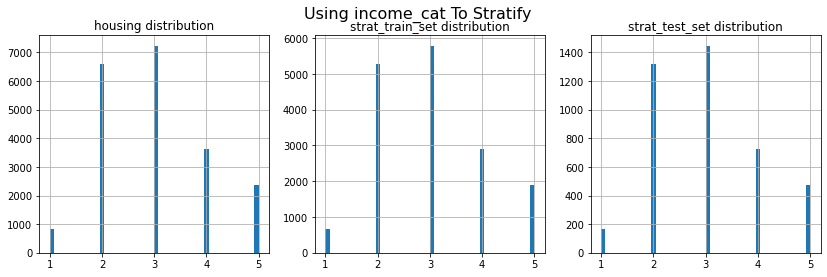

,%in_cat full,train,test
3.0,35.058140,35.059351,35.053295
2.0,31.884690,31.885901,31.879845
4.0,17.630814,17.629603,17.635659
5.0,11.443798,11.446221,11.434109
1.0,3.982558,3.978924,3.997093


In [59]:
# Added features to the original houring dataframe so now a 
# re-split with stratficiation is needed

for train_index, test_index in strat_split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# If we were to automate a process checking %deviation of key metric distribution [full, train, test] data...
s1 = housing['income_cat'].value_counts()/len(housing)*100
s2 = strat_train_set['income_cat'].value_counts()/len(strat_train_set)*100
s3 = strat_test_set['income_cat'].value_counts()/len(strat_test_set)*100
df1 = pd.concat([s1, s2, s3], axis=1)
df1.columns = ['%in_cat full', 'train', 'test']
    
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Using income_cat To Stratify', fontsize=16)
housing['income_cat'].hist(bins=50, ax=ax[0]).set_title('housing distribution')
strat_train_set['income_cat'].hist(bins=50, ax=ax[1]).set_title('strat_train_set distribution')
strat_test_set['income_cat'].hist(bins=50, ax=ax[2]).set_title('strat_test_set distribution')

plt.show()
display(df1)

In [34]:
attributes = ['median_house_value', 'median_income']
# attributes += ['rooms_per_household', 'bedrooms_per_room', 'population_per_household']
# attributes += ['income_to_rooms', 'income_to_bedrooms']
attributes

['median_house_value', 'median_income']

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>]],
      dtype=object)

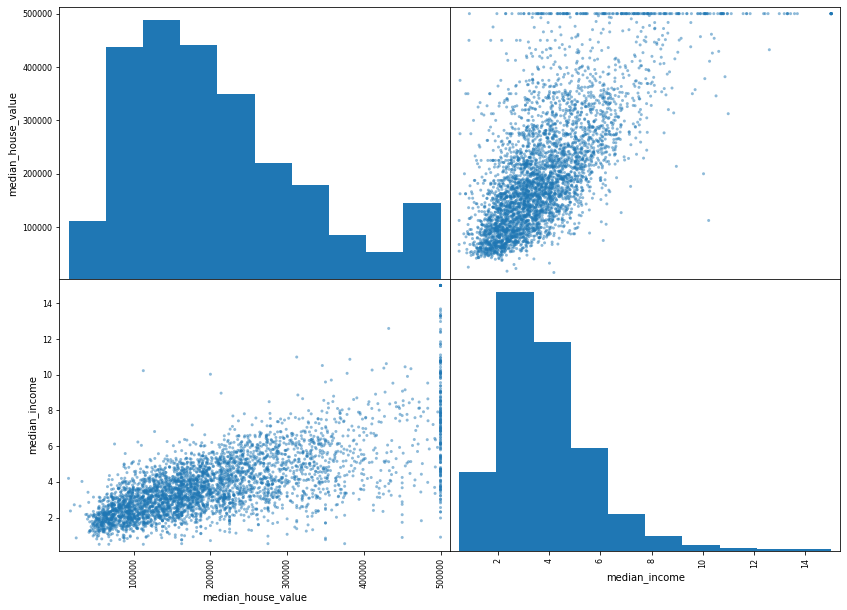

In [35]:
scatter_matrix(strat_test_set[attributes], figsize=(14,10))

In [36]:
# Notice the charts are getting more challenging to look at!

# Looking at the full matrix of correlations...
corr_matrix = housing.corr()
display(corr_matrix)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,id,rooms_per_household,bedrooms_per_room,population_per_household,income_to_rooms,income_to_bedrooms
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967,-0.011272,-0.061647,-0.027540,0.092657,0.002476,-0.012792,-0.018937
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160,-0.079676,0.026985,0.106389,-0.113815,0.002366,0.006998,0.011054
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623,-0.116386,-0.183518,-0.153277,0.136089,0.013191,0.025546,0.022698
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153,0.192523,0.064198,0.133798,-0.187900,-0.024581,-0.094397,-0.071850
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686,-0.006902,0.035934,0.001538,0.084238,-0.028355,-0.103839,-0.084192
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650,0.004307,0.030876,-0.072213,0.035319,0.069863,-0.086592,-0.071584
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843,0.012956,0.034020,-0.080598,0.065087,-0.027309,-0.104673,-0.084300
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075,0.975347,0.075203,0.326895,-0.615661,0.018766,0.103350,0.130665
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000,0.668189,0.078035,0.151948,-0.255880,-0.023737,0.041348,0.057641
income_cat,-0.011272,-0.079676,-0.116386,0.192523,-0.006902,0.004307,0.012956,0.975347,0.668189,1.000000,0.071515,0.320218,-0.599048,0.016150,0.104596,0.132093


In [37]:
# We're really trying to look for features that correlate somewhat to 'median_house_value' so focus on that column

FS2 = corr_matrix['median_house_value'].sort_values(ascending=False).copy()

# and look at a quick "before & after"
display(FS1)
display(FS2)

median_house_value    1.000000
median_income         0.690517
income_cat            0.672175
total_rooms           0.127460
id                    0.108698
housing_median_age    0.080876
households            0.066136
total_bedrooms        0.051907
population           -0.024193
longitude            -0.049608
latitude             -0.142077
Name: median_house_value, dtype: float64

median_house_value          1.000000
median_income               0.688075
income_cat                  0.668189
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
id                          0.078035
households                  0.065843
income_to_bedrooms          0.057641
total_bedrooms              0.049686
income_to_rooms             0.041348
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [38]:
# Re-inspect the dataframe
#
display(housing.info())

# we still need a bunch of "Data clean-up & fix-up" before we focus on "Feature Engineering"
# Also notice, we started with a dataframe that took 1.6MB and with fewer than 2x added features it almost doubled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  object 
 10  income_cat                20640 non-null  float64
 11  id                        20640 non-null  float64
 12  rooms_per_household       20640 non-null  float64
 13  bedrooms_per_room         20433 non-null  float64
 14  popula

None

In [39]:
# Clean-up time... 

# Look at what records have total_bedrooms NaN

no_beds = strat_train_set.loc[strat_train_set['total_bedrooms'].isna()]
display(no_beds.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,id
count,156.000000,156.000000,156.00000,156.000000,0.0,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,-119.680128,35.720705,30.00000,2513.044872,NaN,1500.865385,511.083333,3.696756,200856.448718,2.987179,5955.423878
std,2.014087,2.112731,11.42493,1793.935372,NaN,1104.784405,403.067736,1.940246,110598.340223,1.329502,6160.656773
min,-124.130000,32.730000,5.00000,238.000000,NaN,191.000000,67.000000,0.852700,45800.000000,1.000000,-4323.983200
25%,-121.935000,34.037500,22.75000,1307.750000,NaN,797.750000,258.500000,2.559475,126575.000000,2.000000,694.904275
50%,-118.655000,34.290000,31.00000,2048.000000,NaN,1193.000000,426.500000,3.264900,169950.000000,3.000000,5097.285000
75%,-118.167500,37.675000,38.00000,3296.250000,NaN,1888.750000,623.750000,4.326050,263950.000000,3.000000,11479.875000
max,-114.590000,40.920000,52.00000,11709.000000,NaN,7604.000000,3589.000000,15.000100,500001.000000,11.000000,16414.278400


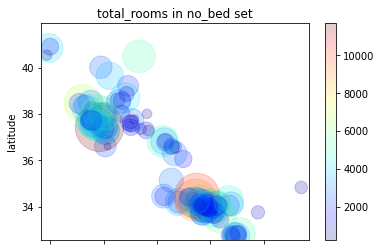

In [40]:
# Get a visual on the location of our missing bedroom info... is it just localized or widespread?

no_beds.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, s=no_beds['total_rooms']/5,
                    c=no_beds['total_rooms'], cmap=plt.get_cmap('jet'), colorbar=True,
                    xlim=(housing['longitude'].min(), housing['longitude'].max()),
                    ylim=(housing['latitude'].min(), housing['latitude'].max()),
            ).set_title('total_rooms in no_bed set')

plt.show()

In [41]:
# Looks pretty wide-spread but the counts are relatively low (158 in the no_beds dataframe)

strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,id
count,16512.000000,16512.000000,16512.000000,16512.000000,16356.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.571860,35.635516,28.633721,2628.436955,535.692345,1421.965540,497.690286,3.873393,206962.764898,3.093084,6055.565693
std,2.002105,2.137953,12.582583,2155.690963,413.240885,1119.674776,376.108851,1.899090,115586.518289,1.303219,5955.984829
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000,-4630.072400
25%,-121.800000,33.930000,18.000000,1444.000000,295.000000,785.000000,279.000000,2.566775,119800.000000,2.000000,1135.187825
50%,-118.510000,34.260000,29.000000,2122.000000,434.000000,1166.000000,408.000000,3.540900,179500.000000,3.000000,6343.857000
75%,-118.010000,37.720000,37.000000,3146.000000,645.000000,1720.000000,602.000000,4.744475,264100.000000,4.000000,11314.062750
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,11.000000,16434.748300


In [42]:
# Compare the stats if we drop the NaN
strat_train_set.dropna(subset=['total_bedrooms']).describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,id
count,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000
mean,-119.570827,35.634703,28.620690,2629.537540,535.692345,1421.213011,497.562546,3.875077,207021.005625,3.094094,6056.520824
std,2.002025,2.138240,12.592716,2158.865557,413.240885,1119.822409,375.853315,1.898675,115634.742754,1.302965,5954.185485
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000,-4630.072400
25%,-121.800000,33.930000,18.000000,1446.000000,295.000000,784.000000,279.000000,2.567000,119800.000000,2.000000,1139.131000
50%,-118.510000,34.260000,29.000000,2123.000000,434.000000,1165.000000,408.000000,3.544250,179500.000000,3.000000,6353.351200
75%,-118.010000,37.720000,37.000000,3145.000000,645.000000,1717.000000,602.000000,4.747575,264100.000000,4.000000,11312.003375
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,11.000000,16434.748300


In [43]:
# Data Engineering (clean-up and fixes should be done before exploring Feature Engineering)
#
# Use ML to fix missing 'total_bedrooms' data
#

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer as Imputer

imputer = Imputer(strategy='median')

train_set_num = strat_train_set.drop('ocean_proximity', axis=1)

imputer.fit(train_set_num)
# print(imputer.statistics_)
X = imputer.transform(train_set_num)

train_num_chk = pd.DataFrame(X, columns=train_set_num.columns)
# But need to recompute features that had anything to do with total_bedrooms with the inferred values
train_num_chk['bedrooms_per_room'] = train_num_chk['total_bedrooms'] / train_num_chk['total_rooms']
train_num_chk['income_to_bedrooms'] = train_num_chk['median_income'] / train_num_chk['total_bedrooms']

l = no_beds['id'].tolist()
print('rows imputer estimated total_bedrooms:', len(l))
display(train_num_chk.loc[train_num_chk['id'].isin(l)])

X = train_num_chk.values
print('Double check the shape of X:', X.shape)

rows imputer estimated total_bedrooms: 156


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,id,bedrooms_per_room,income_to_bedrooms
113,-118.30,34.07,18.0,3759.0,434.0,3296.0,1462.0,2.2708,175000.0,2.0,598.5190,0.115456,0.005232
116,-117.86,34.01,16.0,4632.0,434.0,3038.0,727.0,5.1762,264400.0,4.0,2059.5814,0.093696,0.011927
216,-121.97,37.35,30.0,1955.0,434.0,999.0,386.0,4.6328,287100.0,4.0,13367.4205,0.221995,0.010675
303,-117.30,34.05,6.0,2155.0,434.0,1039.0,391.0,1.6675,95800.0,2.0,9661.9350,0.201392,0.003842
321,-122.79,38.48,7.0,6837.0,434.0,3468.0,1405.0,3.1662,191000.0,3.0,14527.0408,0.063478,0.007295
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16063,-118.37,34.07,50.0,2519.0,434.0,1117.0,516.0,4.3667,405600.0,3.0,658.1341,0.172291,0.010062
16124,-117.76,34.04,34.0,1914.0,434.0,1564.0,328.0,2.8347,115800.0,2.0,2043.4496,0.226750,0.006532
16289,-118.53,34.26,18.0,3674.0,434.0,1590.0,550.0,8.1760,308400.0,6.0,-531.8378,0.118127,0.018839
16326,-119.75,34.45,6.0,2864.0,434.0,1404.0,603.0,5.5073,263800.0,4.0,13072.6125,0.151536,0.012690


Double check the shape of X: (16512, 13)
